In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Tạo bộ tăng cường dữ liệu (data augmentation)
train_datagen = ImageDataGenerator( rescale=1.0/255, 
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [11]:
import os

base_path = "../Project - Copy/Dataset/Emotion/train"
print("Tồn tại:", os.path.exists(base_path))
print("Các lớp có trong thư mục:")
print(os.listdir(base_path))


Tồn tại: True
Các lớp có trong thư mục:
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [12]:
# Áp dụng data augmentation cho tập huấn luyện
train_generator = train_datagen.flow_from_directory(directory="../Project - Copy/Dataset/Emotion/train",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Tạo bộ tăng cường dữ liệu cho tập validation (không thay đổi dữ liệu)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Áp dụng data augmentation cho tập validation
validation_generator = validation_datagen.flow_from_directory(directory="../Project - Copy/Dataset/Emotion/test",
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
train_generator = train_datagen.flow_from_directory(
    directory="../Project - Copy/Dataset/Emotion/train",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    classes=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']  # đúng thứ tự lớp còn lại
)


Found 28273 images belonging to 6 classes.


In [20]:
from keras import Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout

model = Sequential()
model.add(Input(shape=(150, 150, 3)))

# Block 1
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 2
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 3
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 4
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 5
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# # Flatten
# model.add(Flatten())
model.add(GlobalAveragePooling2D())

# Fully-connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(6, activation='softmax'))

In [17]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [21]:
# Compile mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Sử dụng EarlyStopping để dừng quá trình huấn luyện sớm nếu không có cải tiến đáng kể
early_stopping = EarlyStopping(patience=6, monitor='val_loss', restore_best_weights=True)

In [22]:
# Huấn luyện mô hình
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[early_stopping])

Epoch 1/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.2663 - loss: 1.8275

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 7), output.shape=(None, 6)

In [50]:
# Đánh giá độ chính xác của mô hình
score = model.evaluate(train_generator,verbose=0)
print('Sai số kiểm tra là: ',score[0])
print('Độ chính xác kiểm tra là: ',score[1])


Sai số kiểm tra là:  0.9975718259811401
Độ chính xác kiểm tra là:  0.6106055378913879


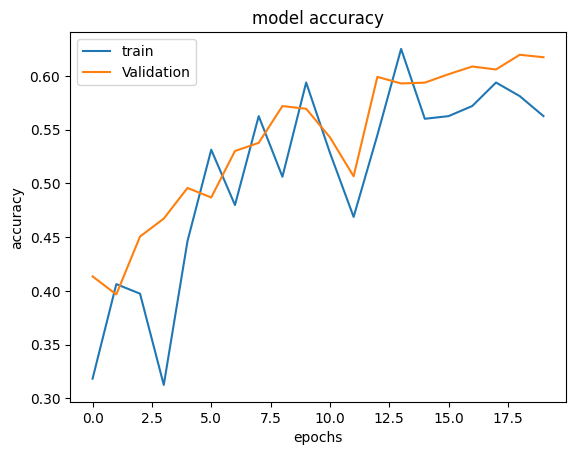

In [51]:
import matplotlib.pyplot as plt
# Draw plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','Validation'])
plt.show()

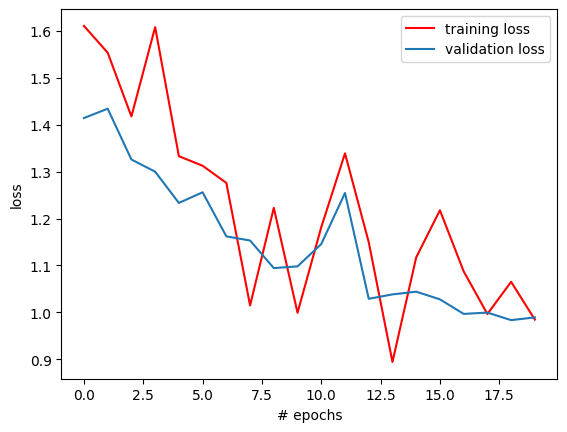

In [53]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [54]:
from tensorflow.keras.models import load_model
model.save('Emotion1.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


array(['Angry'], dtype='<U8')

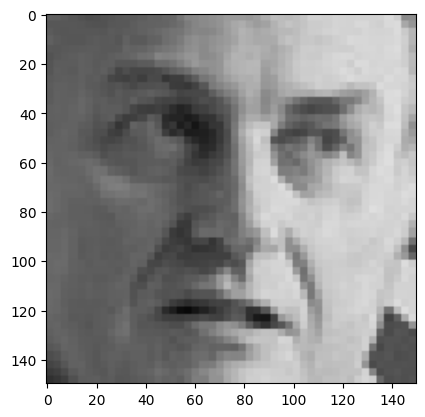

In [55]:
model_CNN = load_model('Emotion1.h5')
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
filename = "../Project - Copy/Dataset/Emotion/test/sad/PrivateTest_10247676.jpg"

predict = ['Neutral','Happy','Sad','Angry','Suprised']
predict = np.array(predict)
img = load_img(filename,target_size=(150,150))
plt.imshow(img)

img = img_to_array(img)
img = img.reshape(1,150,150,3)
img = img.astype('float32')
img = img/255


result = np.argmax(model_CNN.predict(img),axis=-1)
predict[result]